## Setup

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
import math

In [2]:
# Import data
tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_train_set_no_zeros.csv")


# Quick inspection
tor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 28 columns):
EVENT_ID              4803 non-null int64
INJURIES_DIRECT       4803 non-null int64
DEATHS_DIRECT         4803 non-null int64
DAMAGE_PROPERTY       4803 non-null float64
DAMAGE_CROPS          4803 non-null float64
DURATION_SECONDS      4803 non-null float64
BEGIN_LAT             4803 non-null float64
BEGIN_LON             4803 non-null float64
TOR_LENGTH            4803 non-null float64
TOR_WIDTH             4803 non-null float64
BEGIN_DATE_TIME       4803 non-null float64
YEAR                  4803 non-null int64
CZ_NAME               4803 non-null object
OPEN_WATER_PROP       4803 non-null float64
DEV_OPEN_PROP         4803 non-null float64
DEV_LOW_PROP          4803 non-null float64
DEV_MED_PROP          4803 non-null float64
DEV_HIGH_PROP         4803 non-null float64
DECID_FOREST_PROP     4803 non-null float64
EVERGR_FOREST_PROP    4803 non-null float64
MIXED_FOREST_PROP     

In [3]:
# Seperating variables
# The dependent variables
tornado_outcomes = tor_df.iloc[:, [3]].astype(float)


# Quick inspection
tornado_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 1 columns):
DAMAGE_PROPERTY    4803 non-null float64
dtypes: float64(1)
memory usage: 37.6 KB


In [4]:
# The independent variables
tornado_features = tor_df.iloc[:, 5:]


# Get rid of year and county name
tornado_features = tornado_features.drop(["YEAR",
                                          "CZ_NAME"],
                                         axis = 1)



# Quick inspection
tornado_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 21 columns):
DURATION_SECONDS      4803 non-null float64
BEGIN_LAT             4803 non-null float64
BEGIN_LON             4803 non-null float64
TOR_LENGTH            4803 non-null float64
TOR_WIDTH             4803 non-null float64
BEGIN_DATE_TIME       4803 non-null float64
OPEN_WATER_PROP       4803 non-null float64
DEV_OPEN_PROP         4803 non-null float64
DEV_LOW_PROP          4803 non-null float64
DEV_MED_PROP          4803 non-null float64
DEV_HIGH_PROP         4803 non-null float64
DECID_FOREST_PROP     4803 non-null float64
EVERGR_FOREST_PROP    4803 non-null float64
MIXED_FOREST_PROP     4803 non-null float64
SHRUB_SCRUB_PROP      4803 non-null float64
GRASS_LAND_PROP       4803 non-null float64
PASTURE_HAY_PROP      4803 non-null float64
CULT_CROPS_PROP       4803 non-null float64
WOOD_WETLAND_PROP     4803 non-null float64
HERB_WETLAND_PROP     4803 non-null float64
BARREN_LAND_P

In [5]:
# Make the dependent variables into a numpy array
outcomes_array = tornado_outcomes.values


# Makes the numpy array into a torch Tensor
outcomes_Tensor = torch.from_numpy(outcomes_array)


# Quick inspection
outcomes_Tensor


 0.3534
 0.9965
 1.3980
   ⋮    
 0.8757
 0.9464
 1.1563
[torch.DoubleTensor of size 4803x1]

In [6]:
# Make the independent variables into a numpy array
features_array = tornado_features.values


# Make the numpy array into a torch Tensor
features_Tensor = torch.from_numpy(features_array)


# Quick inspection
features_Tensor


 4.6236e-01 -3.3757e-01 -7.0216e-01  ...  -1.2423e+00  5.9959e-01 -6.9525e-01
 4.6236e-01  9.2274e-01 -6.6432e-01  ...   1.1258e+00 -2.1299e-01 -6.9525e-01
 4.6236e-01 -1.5020e+00  2.9306e-01  ...   1.5639e+00  2.2272e+00  2.5647e+00
                ...                   ⋱                   ...                
 1.9605e-01  5.8469e-01  4.9751e-01  ...  -2.7958e-01 -9.0635e-01 -6.9525e-01
 8.2443e-01  7.4516e-01  1.2537e+00  ...  -1.2423e+00  1.5541e-01  1.2329e-01
 3.4596e-01  7.9864e-01  2.0950e+00  ...   1.6329e-01  4.3847e-01 -6.9525e-01
[torch.DoubleTensor of size 4803x21]

### Convert DoubleTensor to FloatTensor

In [7]:
# Changing dependent variables from a DoubleTensor to a FloatTensor
outcomes_Tensor = outcomes_Tensor.float()


# ...and for the independent variables
features_Tensor = features_Tensor.float()


# Quick check
features_Tensor


 4.6236e-01 -3.3757e-01 -7.0216e-01  ...  -1.2423e+00  5.9959e-01 -6.9525e-01
 4.6236e-01  9.2274e-01 -6.6432e-01  ...   1.1258e+00 -2.1299e-01 -6.9525e-01
 4.6236e-01 -1.5020e+00  2.9306e-01  ...   1.5639e+00  2.2272e+00  2.5647e+00
                ...                   ⋱                   ...                
 1.9605e-01  5.8469e-01  4.9751e-01  ...  -2.7958e-01 -9.0635e-01 -6.9525e-01
 8.2443e-01  7.4516e-01  1.2537e+00  ...  -1.2423e+00  1.5541e-01  1.2329e-01
 3.4596e-01  7.9864e-01  2.0950e+00  ...   1.6329e-01  4.3847e-01 -6.9525e-01
[torch.FloatTensor of size 4803x21]

## Round 1: One-Hidden-Layer Neural Network

In [8]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [9]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                            torch.nn.ReLU(),
                            torch.nn.Linear(14, 1))

In [10]:
# Set the loss function
loss_fn = torch.nn.MSELoss(size_average=False)

In [11]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 4e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

In [12]:
# Get the iterations
iterations = list(range(0, 10000))

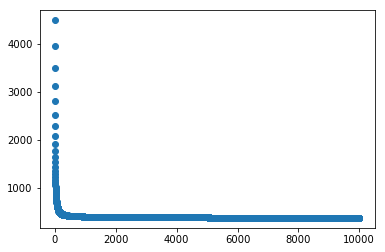

In [13]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [14]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4803)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

In [15]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
outcomes_Variable_resized = outcomes_Variable.resize(4803)


# Make the FloatTensor into a numpy.array
outcomes_array = outcomes_Variable_resized.data.numpy()


# Make the numpy.array into a list
outcomes_list = outcomes_array.tolist()

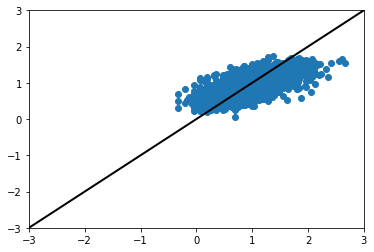

In [16]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-3, 3])

axes.set_ylim([-3, 3])

plt.plot([-3, 3], [-3, 3], 'k-', lw=2)

### Round 1.1: Validation Set Performance

In [17]:
# Import data
valid_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_cv_set_no_zeros.csv")


# Validation set outcomes
valid_outcomes = valid_df.iloc[:, [3]].astype(float)


# Make the validation outcomes into a numpy array
valid_outcomes_array = valid_outcomes.values


# Makes the numpy array into a torch Tensor
valid_outcomes_Tensor = torch.from_numpy(valid_outcomes_array)


# Changing validation outcomes from a DoubleTensor to a FloatTensor
valid_outcomes_Tensor = valid_outcomes_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_outcomes_Variable = Variable(valid_outcomes_Tensor)

In [18]:
# Validation set predictors
valid_predictors = valid_df.iloc[:, 5:]

valid_predictors = valid_predictors.drop(["YEAR",
                                          "CZ_NAME"],
                                         axis = 1)


# Make the validation predictors into a numpy array
valid_predictors_array = valid_predictors.values


# Makes the numpy array into a torch Tensor
valid_predictors_Tensor = torch.from_numpy(valid_predictors_array)


# Changing validation predictors from a DoubleTensor to a FloatTensor
valid_predictors_Tensor = valid_predictors_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_predictors_Variable = Variable(valid_predictors_Tensor)

In [19]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(14, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight


# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 562.4477
[torch.FloatTensor of size 1]

In [20]:
valid_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562 entries, 0 to 1561
Data columns (total 21 columns):
DURATION_SECONDS      1562 non-null float64
BEGIN_LAT             1562 non-null float64
BEGIN_LON             1562 non-null float64
TOR_LENGTH            1562 non-null float64
TOR_WIDTH             1562 non-null float64
BEGIN_DATE_TIME       1562 non-null float64
OPEN_WATER_PROP       1562 non-null float64
DEV_OPEN_PROP         1562 non-null float64
DEV_LOW_PROP          1562 non-null float64
DEV_MED_PROP          1562 non-null float64
DEV_HIGH_PROP         1562 non-null float64
DECID_FOREST_PROP     1562 non-null float64
EVERGR_FOREST_PROP    1562 non-null float64
MIXED_FOREST_PROP     1562 non-null float64
SHRUB_SCRUB_PROP      1562 non-null float64
GRASS_LAND_PROP       1562 non-null float64
PASTURE_HAY_PROP      1562 non-null float64
CULT_CROPS_PROP       1562 non-null float64
WOOD_WETLAND_PROP     1562 non-null float64
HERB_WETLAND_PROP     1562 non-null float64
BARREN_LAND_P

In [21]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1562)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

In [22]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
valid_outcomes_Variable_resized = valid_outcomes_Variable.resize(1562)


# Make the FloatTensor into a numpy.array
valid_outcomes_array = valid_outcomes_Variable_resized.data.numpy()


# Make the numpy.array into a list
valid_outcomes_list = valid_outcomes_array.tolist()

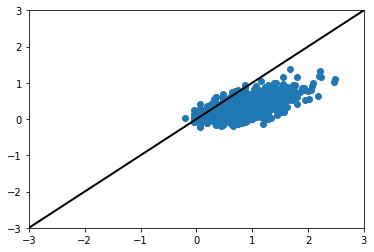

In [23]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-3, 3])

axes.set_ylim([-3, 3])

plt.plot([-3, 3], [-3, 3], 'k-', lw=2)

### Round 1.2: The Model Above has Proven Best; Final Plot against Test Data

In [24]:
# Import data
test_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_test_set_no_zeros.csv")


# Validation set outcomes
test_outcomes = test_df.iloc[:, [3]].astype(float)


# Make the validation outcomes into a numpy array
test_outcomes_array = test_outcomes.values


# Makes the numpy array into a torch Tensor
test_outcomes_Tensor = torch.from_numpy(test_outcomes_array)


# Changing validation outcomes from a DoubleTensor to a FloatTensor
test_outcomes_Tensor = test_outcomes_Tensor.float()


# Make the Tensor into a Pytorch Variable
test_outcomes_Variable = Variable(test_outcomes_Tensor)

In [25]:
# Validation set predictors
test_predictors = test_df.iloc[:, 5:]

test_predictors = test_predictors.drop(["YEAR",
                                        "CZ_NAME"],
                                       axis = 1)


# Make the validation predictors into a numpy array
test_predictors_array = test_predictors.values


# Makes the numpy array into a torch Tensor
test_predictors_Tensor = torch.from_numpy(test_predictors_array)


# Changing validation predictors from a DoubleTensor to a FloatTensor
test_predictors_Tensor = test_predictors_Tensor.float()


# Make the Tensor into a Pytorch Variable
test_predictors_Variable = Variable(test_predictors_Tensor)

In [26]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model_2 = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(14, 1))


# Give the new model the old model's parameters
dim_corrected_model_2[(0)].weight = model[(0)].weight
dim_corrected_model_2[(2)].weight = model[(2)].weight


# Get the validation set predictions
y_test_pred = dim_corrected_model_2(test_predictors_Variable)


# Print the loss
loss_fn(y_test_pred,
        test_outcomes_Variable)

Variable containing:
 938.7471
[torch.FloatTensor of size 1]

In [27]:
test_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1595 entries, 0 to 1594
Data columns (total 21 columns):
DURATION_SECONDS      1595 non-null float64
BEGIN_LAT             1595 non-null float64
BEGIN_LON             1595 non-null float64
TOR_LENGTH            1595 non-null float64
TOR_WIDTH             1595 non-null float64
BEGIN_DATE_TIME       1595 non-null float64
OPEN_WATER_PROP       1595 non-null float64
DEV_OPEN_PROP         1595 non-null float64
DEV_LOW_PROP          1595 non-null float64
DEV_MED_PROP          1595 non-null float64
DEV_HIGH_PROP         1595 non-null float64
DECID_FOREST_PROP     1595 non-null float64
EVERGR_FOREST_PROP    1595 non-null float64
MIXED_FOREST_PROP     1595 non-null float64
SHRUB_SCRUB_PROP      1595 non-null float64
GRASS_LAND_PROP       1595 non-null float64
PASTURE_HAY_PROP      1595 non-null float64
CULT_CROPS_PROP       1595 non-null float64
WOOD_WETLAND_PROP     1595 non-null float64
HERB_WETLAND_PROP     1595 non-null float64
BARREN_LAND_P

In [28]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_test_pred_resized = y_test_pred.resize(1595)


# Make the FloatTensor into a numpy.array
y_test_pred_array = y_test_pred_resized.data.numpy()


# Convert back to native units and scale
y_test_pred_array = y_test_pred_array*5.735285 + 6.490682


# Make the numpy.array into a list
y_test_pred_list = y_test_pred_array.tolist()

In [29]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
test_outcomes_Variable_resized = test_outcomes_Variable.resize(1595)


# Make the FloatTensor into a numpy.array
test_outcomes_array = test_outcomes_Variable_resized.data.numpy()


# Convert back to native units and scale
test_outcomes_array = test_outcomes_array*5.735285 + 6.490682


# Make the numpy.array into a list
test_outcomes_list = test_outcomes_array.tolist()

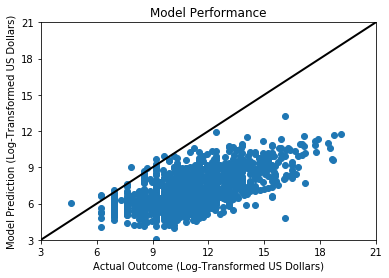

In [30]:
# Plot new predictions versus new data outcomes

plt.scatter(test_outcomes_list, y_test_pred_list)

axes = plt.gca()

axes.set_xlim([3, 21])

axes.set_ylim([3, 21])

axes.set_xticks([3, 6, 9, 12, 15, 18, 21])

axes.set_yticks([3, 6, 9, 12, 15, 18, 21])

plt.plot([3, 21], [3, 21], 'k-', lw=2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [31]:
dim_corrected_model_2[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.0881 -0.0230 -0.2489 -0.0667 -0.1618  0.1099 -0.0228 -0.1613 -0.0898  0.1364
-0.0604 -0.1527  0.0817  0.1419  0.2125 -0.0112 -0.0995  0.1194 -0.0622  0.0712
-0.2275  0.1169  0.1855  0.1574 -0.2206  0.1974 -0.0656  0.0718  0.1141 -0.0334
 0.1717  0.2067  0.0198  0.2464  0.1677  0.0406  0.1298 -0.2473  0.1249  0.2495
 0.1479  0.0312 -0.2361 -0.1615  0.0945 -0.0324  0.1679 -0.0267 -0.1439  0.1479
 0.0900  0.2079  0.0146  0.1317 -0.0032 -0.0059 -0.1216  0.0435  0.0056 -0.0827
 0.2074  0.0361  0.2085 -0.0359 -0.0065 -0.1388  0.2215  0.1393 -0.0133  0.0356
 0.0883  0.0299 -0.1242 -0.0559 -0.1379  0.2156 -0.0776  0.1251  0.1558  0.0998
-0.0172 -0.0178  0.1209  0.1828  0.2017 -0.1554  0.0528 -0.0724 -0.0331 -0.1126
-0.2103  0.1272  0.0866 -0.1959 -0.1930 -0.1469  0.0309  0.0268 -0.0132  0.1170
 0.1117 -0.0993  0.1154  0.1121 -0.2063 -0.0653 -0.1488 -0.0570  0.1138 -0.1583
 0.3059 -0.1061  0.0986  0.1421  0.1327  0.0367  0.0048  0.1153  0.2197 -0.0273
-

In [32]:
dim_corrected_model_2[(2)].weight

Parameter containing:

Columns 0 to 9 
-0.1169  0.1632 -0.0930  0.1818 -0.0520  0.1344 -0.0281  0.1461  0.2254 -0.0500

Columns 10 to 13 
-0.0390  0.2441  0.1644 -0.2069
[torch.FloatTensor of size 1x14]

## Round 2: Two-Hidden-Layer Neural Network

In [33]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [34]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                            torch.nn.ReLU(),
                            torch.nn.Linear(14, 9),
                            torch.nn.ReLU(),
                            torch.nn.Linear(9, 1))

In [35]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 6e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

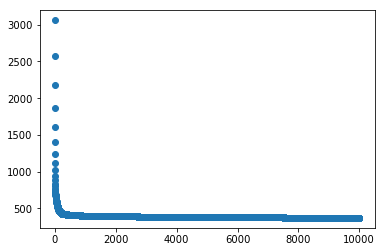

In [36]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [37]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4803)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

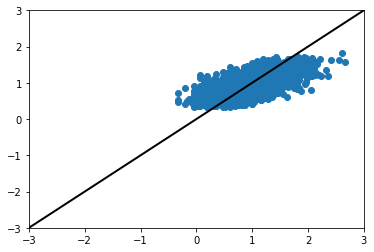

In [38]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-3, 3])

axes.set_ylim([-3, 3])

plt.plot([-3, 3], [-3, 3], 'k-', lw=2)

### Round 2.1: Validation Set Performance

In [39]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(14, 9),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(9, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight
dim_corrected_model[(4)].weight = model[(4)].weight


# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 219.7318
[torch.FloatTensor of size 1]

In [40]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1562)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

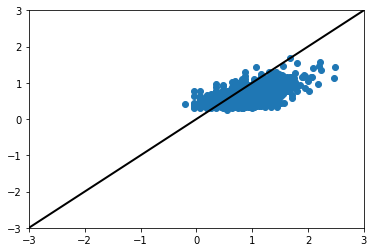

In [41]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-3, 3])

axes.set_ylim([-3, 3])

plt.plot([-3, 3], [-3, 3], 'k-', lw=2)

## Round 3: Three-Hidden-Layers Neural Network

In [42]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [43]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                            torch.nn.ReLU(),
                            torch.nn.Linear(14, 9),
                            torch.nn.ReLU(),
                            torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 1))

In [44]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 5e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

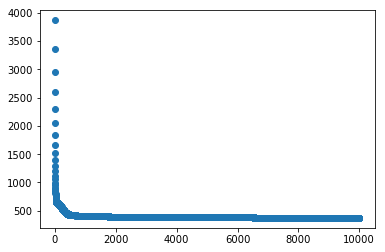

In [45]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [46]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4803)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

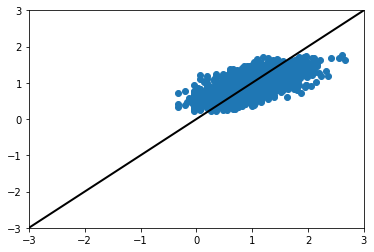

In [47]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-3, 3])

axes.set_ylim([-3, 3])

plt.plot([-3, 3], [-3, 3], 'k-', lw=2)

### Round 3.1: Validation Set Performance

In [48]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(14, 9),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(9, 6),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(6, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight
dim_corrected_model[(4)].weight = model[(4)].weight
dim_corrected_model[(6)].weight = model[(6)].weight


# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 608.3737
[torch.FloatTensor of size 1]

In [49]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1562)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

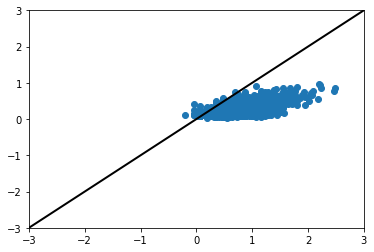

In [50]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-3, 3])

axes.set_ylim([-3, 3])

plt.plot([-3, 3], [-3, 3], 'k-', lw=2)

## Round 4: Linear Regression

In [51]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [52]:
# Make the neural network - really a regression
model = torch.nn.Sequential(torch.nn.Linear(21, 1))

In [53]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 4e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

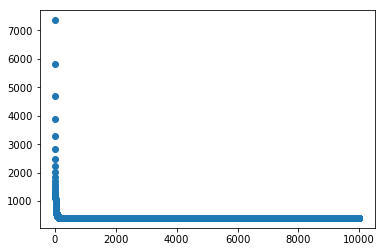

In [54]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [55]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4803)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

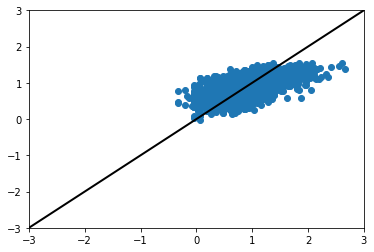

In [56]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-3, 3])

axes.set_ylim([-3, 3])

plt.plot([-3, 3], [-3, 3], 'k-', lw=2)

### Round 4.1: Validation Set Performance

In [57]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(21, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight


# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 1114.8816
[torch.FloatTensor of size 1]

In [58]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1562)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

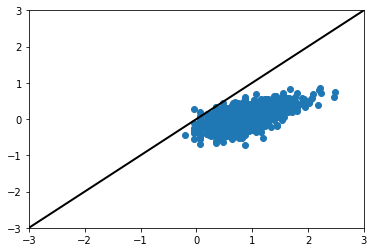

In [59]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-3, 3])

axes.set_ylim([-3, 3])

plt.plot([-3, 3], [-3, 3], 'k-', lw=2)